# MODELO CAPM

LA pregunta ahora es:

- ¿Qué ocurre si introducimos un **ACTIVO LIBRE DE RIESGO** al universo de activos?

- El activo libre de riesgo lo denotaremos como **$\Large R_f$**

Las principal característica del activo libre de riesgo $R_f$ es:

- **Retorno Garantizado**: Ofrece un retorno fijo y conocido de antemano.

- **Ejemplos Comunes**: Bonos del gobierno de países estables, como los bonos del Tesoro de EE. UU.


- **Incorporación de un Activo Libre de Riesgo**: Al agregar un activo libre de riesgo al universo de activos, se permite combinar posiciones en la frontera eficiente con el activo libre de riesgo.
  
- **Posiciones Largas y Cortas**: Tomar una posición larga en el activo libre de riesgo equivale a prestar dinero, mientras que una posición corta es similar a pedir prestado a la tasa libre de riesgo.
  
- **Ampliación del Conjunto de Oportunidades**: Al introducir préstamo y endeudamiento a la tasa libre de riesgo, se expande el conjunto de oportunidades de inversión.
  
- **Comparación de Carteras en la Frontera Eficiente**: Interesa analizar cómo se compara una cartera en la frontera eficiente con otra que utiliza préstamo o endeudamiento para igualar el retorno esperado de otro punto en la frontera.
  
- **Ejemplo Práctico**: Consideración de dos carteras en la frontera eficiente para evaluar el impacto del préstamo y el endeudamiento.


VEamos qué pasa si añadimos el **activo libre de riesgo** como un activo más a los datos del tema anterior:

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import cvxpy as cp
import yfinance as yf
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB
from scipy.interpolate import interp1d

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [12, 8]



pd.options.display.float_format = '{:.4%}'.format

#### Descargamos los datos y calculamos retornos y matriz de covarianzas

In [2]:
# Date range
start = '2015-01-01'
end = '2019-12-30'

# Assets todos con retornos positivos
assets_positivos = ['BA', 'BAX', 'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'HPQ', 'JCI', 'JPM',
        'LUV', 'MMC', 'MO', 'NI', 'PCAR', 'PSA', 'SEE', 'T', 'TGT', 'TMO',
        'TXT', 'VZ', 'ZION']

assets_muy_negativos = ['BA', 'BAX', 'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'F', 'GE', 'HPQ', 
        'JCI', 'JPM','KHC', 'LUV', 'MMC', 'MO', 'NI', 'PCAR', 'PSA', 'SEE', 
        'T', 'TGT', 'TMO','TXT', 'VZ', 'ZION']

assets_un_negativo = ['BA', 'BAX', 'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'F', 'HPQ', 
        'JCI', 'JPM', 'LUV', 'MMC', 'MO', 'NI', 'PCAR', 'PSA', 'SEE', 
        'T', 'TGT', 'TMO','TXT', 'VZ', 'ZION']

assets = assets_muy_negativos



# Downloading data
prices = yf.download(assets, start = start, end = end)['Adj Close']
prices.columns = assets

[*********************100%%**********************]  26 of 26 completed


In [3]:
# Número de activos
num_act = prices.shape[1]

In [4]:
returns = np.log(prices / prices.shift(1)).dropna()
returns.head(2)

,BA,BAX,BMY,CMCSA,CNP,CPB,DE,F,GE,HPQ,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-07,1.8543%,-2.4752%,1.0757%,0.6420%,1.9578%,1.4908%,0.7402%,0.4048%,0.6063%,0.7495%,...,1.6490%,0.3578%,2.2570%,0.3248%,0.4483%,1.8163%,0.4285%,-0.3387%,0.4454%,-2.1060%
2015-07-08,-0.8629%,-1.6574%,-0.7208%,-1.3205%,-1.9578%,-0.8582%,-1.3805%,-3.2857%,-2.2155%,-1.1429%,...,0.1168%,-2.3246%,0.3109%,-2.3935%,-1.0230%,-1.1553%,-2.1224%,-2.8681%,-0.2573%,-2.6208%


In [5]:
#Calculamos la matriz de covarianzas y los retornos esperados
matriz_cov = returns.cov().to_numpy() # Covariance matrix
retornos_esperados = returns.mean().to_numpy() # Column vector expected return

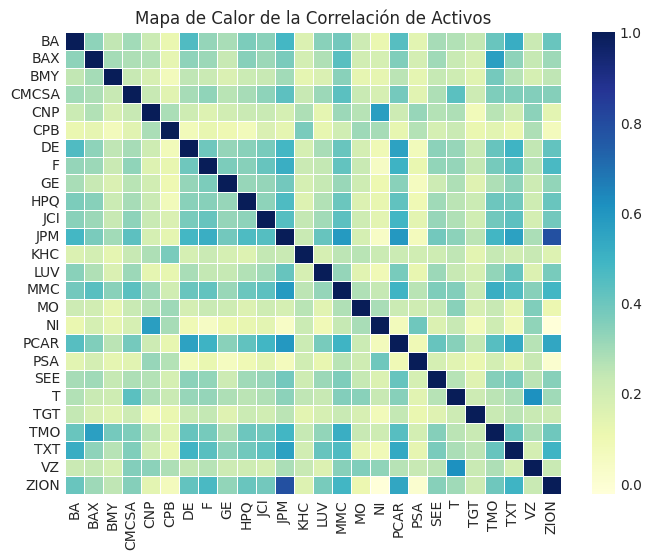

In [6]:
# Correlation matrix
mat_corr = returns.corr().to_numpy() 

# Configurando el tamaño de la figura
plt.figure(figsize=(8, 6))
sns.heatmap(mat_corr, linewidths=.5, cmap="YlGnBu", xticklabels=assets, yticklabels=assets)
# Añadiendo título
plt.title("Mapa de Calor de la Correlación de Activos")

# Mostrando la gráfica
plt.show()

#### Calculamos la frontera eficiente usando Markpwitz

In [7]:
#Variables de decisión
pesos = cp.Variable(num_act)

# Factor aversión al riesgo
gamma = cp.Parameter(nonneg=True)

ret = retornos_esperados.T @ pesos

riesgo = cp.quad_form(pesos, matriz_cov)

In [8]:
objetivo = cp.Maximize(ret - gamma*riesgo)

In [9]:
#Restricciones y función objetivo
constraints = [pesos >= 0,
                cp.sum(pesos) == 1
                ]

prob = cp.Problem(objetivo, constraints)

In [10]:
#resolvemos para diferentes valores de gamma
num_sim = 100
riesgos_res = np.zeros(num_sim)
retornos_res = np.zeros(num_sim)
pesos_res = np.zeros((num_sim, num_act))
gamma_vals = np.logspace(-2, 3, num=num_sim)

for i in range(num_sim):
    gamma.value = gamma_vals[i]
    prob.solve()
    retornos_res[i] = ret.value
    riesgos_res[i] = cp.sqrt(riesgo).value
    pesos_res[i, :] = pesos.value

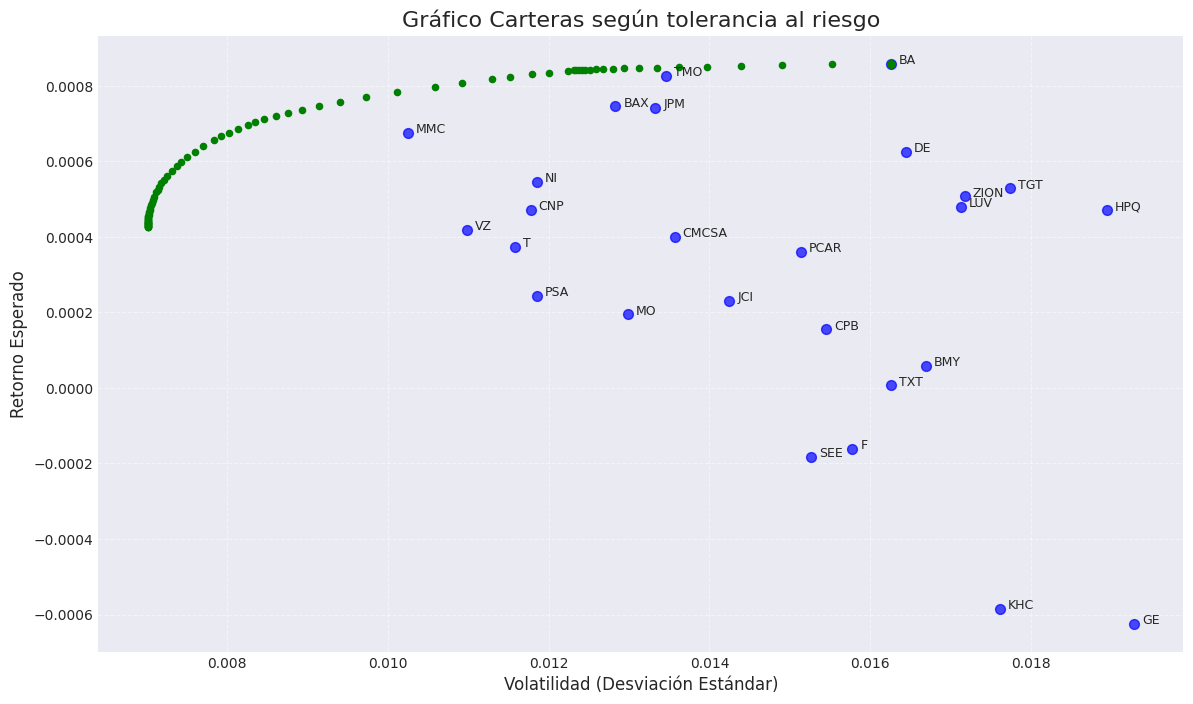

In [11]:
# Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(14, 8))
plt.style.use('seaborn-v0_8-darkgrid')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, label='Activos', alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00002  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)

plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')#,  alpha=0.3)   

# Añadiendo títulos y etiquetas
plt.title('Gráfico Carteras según tolerancia al riesgo', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()

#### Añadimos el acivo libre de riesgo:

Añado una columna al la matriz de retornos con un valor constante:

- Como los retornos $r_f$ son constantes $\Rightarrow$ La varianza es cero **$\quad \Large \sigma^2_f = 0$**

- Además las covarianzas son también cero **$\quad \Large \sigma_{f, i} = 0 \quad \forall\ r_i $**

Veamos cómo sale la matriz de correlaciones con el nuevo activo

In [12]:
returns['RF'] = 0.0001 #Añadimos la columna de la tasa libre de riesgo

if 'RF' not in assets: #Si no está la tasa libre de riesgo en los activos, la añadimos
    assets.append('RF')

num_act = len(assets)

matriz_cov = returns.cov().to_numpy() # Covariance matrix
retornos_esperados = returns.mean().to_numpy() # Column vector expected return
riesgos_esperados = np.sqrt(np.diag(matriz_cov)) # Column vector expected risk

Veamos cómo varía la matriz de correlaciones al meter el activo

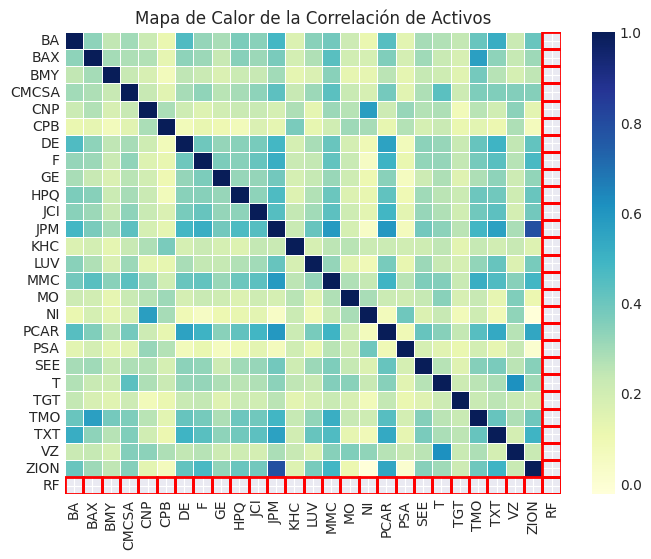

In [13]:
# Correlation matrix
mat_corr = returns.corr().to_numpy() 

# Configurando el tamaño de la figura
plt.figure(figsize=(8, 6))
sns.heatmap(mat_corr, linewidths=.5, cmap="YlGnBu", xticklabels=assets, yticklabels=assets)
# Añadiendo título
plt.title("Mapa de Calor de la Correlación de Activos")

# Añadir recuadros rojos a la última fila y columna
for i in range(len(assets)):
    plt.gca().add_patch(plt.Rectangle((i, len(assets)-1), 1, 1, fill=False, edgecolor='red', lw=2))
    plt.gca().add_patch(plt.Rectangle((len(assets)-1, i), 1, 1, fill=False, edgecolor='red', lw=2))


# Mostrando la gráfica
plt.show()

VAmos a calcular la fronetra eficiente con las siguiente condiciones:

- Existe un activo libre de riesgo $R_f$

- Se permite pedir dinero prestado a la tasa libre de riesgo (posición corta en ese activo)

- La pocición del activo libre de riesgo es la última

- No se permiten posiciones cortas en el resto de activos

In [33]:
#Variables de decisión
pesos = cp.Variable(num_act, name='pesos')

# Factor aversión al riesgo
gamma = cp.Parameter(nonneg=True, name='gamma')

ret = retornos_esperados.T @ pesos

riesgo = cp.quad_form(pesos, matriz_cov)

In [34]:
#Función objetivo
objetivo = cp.Maximize(ret - gamma*riesgo)

In [35]:
#REstricción para que todos los pesos, excepto el de la RF sean positivos
# Se supone que la RF es la última posición

constraints = [ 
                pesos[:-1] >= 0, #Todos los pesos, excepto el de la RF son positivos
                cp.sum(cp.abs(pesos)) <= 5, #Suma de los pesos en valor absoluto es menor o igual a 5
                cp.sum(pesos) == 1 #Suma de los pesos es igual a 1
                ]

prob = cp.Problem(objetivo, constraints)

In [36]:
#resolvemos para diferentes valores de gamma

num_sim = 3000
riesgos_res_rf = np.zeros(num_sim)
retornos_res_rf = np.zeros(num_sim)
pesos_res_rf = np.zeros((num_sim, num_act))
gamma_vals = np.logspace(-2, 3, num=num_sim)
#gamma_vals = np.linspace(0, 500, num=num_sim)

for i in range(num_sim):
    gamma.value = gamma_vals[i]
    prob.solve()
    retornos_res_rf[i] = ret.value
    riesgos_res_rf[i] = cp.sqrt(riesgo).value
    pesos_res_rf[i, :] = pesos.value

In [37]:
# Limito la gráfica a los valores que me interesan

factor_riesgo_grafica = 1.2
retornos_res_rf = retornos_res_rf[riesgos_res_rf < factor_riesgo_grafica*riesgos_res.max()]

riesgos_res_rf = riesgos_res_rf[riesgos_res_rf < factor_riesgo_grafica*riesgos_res.max()]

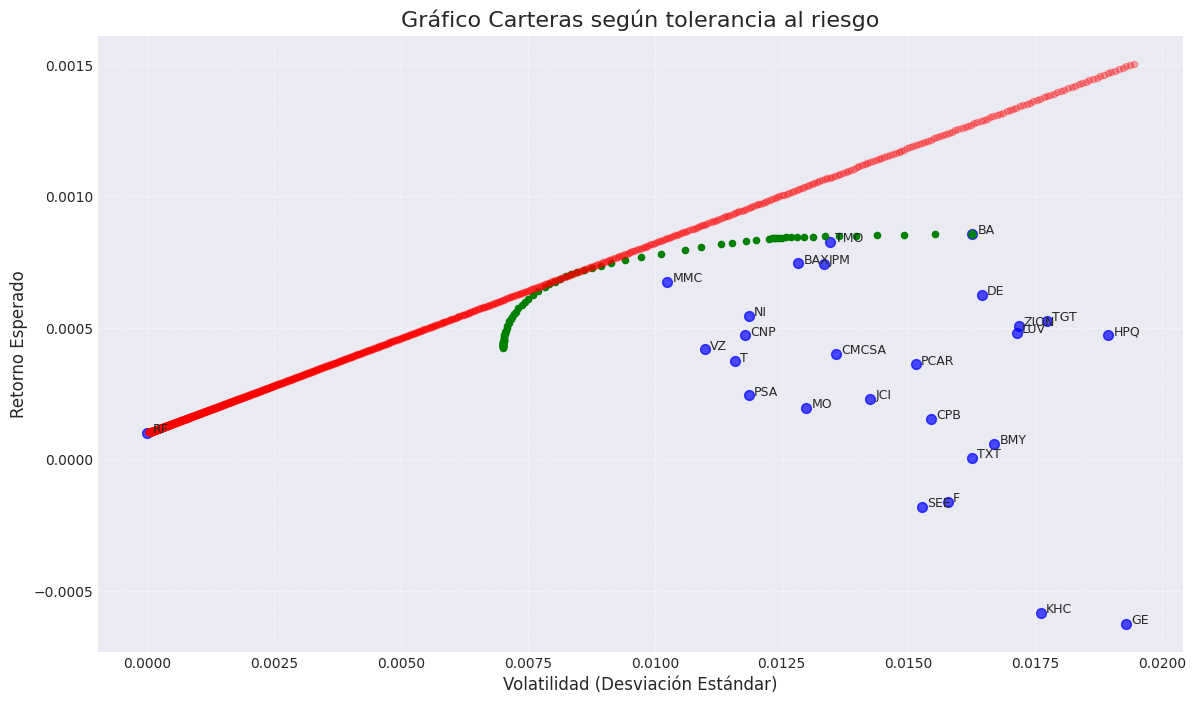

In [38]:
# Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(14, 8))
plt.style.use('seaborn-v0_8-darkgrid')

# Puntos de cada activo
plt.scatter(riesgos_esperados, retornos_esperados, color='blue', s=50, label='Activos', alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00002  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(riesgos_esperados[i] + desplazamiento_x, retornos_esperados[i] , assets[i], fontsize=9)

plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')#,  alpha=0.3)  
plt.scatter(riesgos_res_rf, retornos_res_rf, color='red', s=20, marker='o',  alpha=0.3)

# Añadiendo títulos y etiquetas
plt.title('Gráfico Carteras según tolerancia al riesgo', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()

/tmp/ipykernel_52675/420231551.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  paleta = cm.get_cmap('Spectral', num_act)


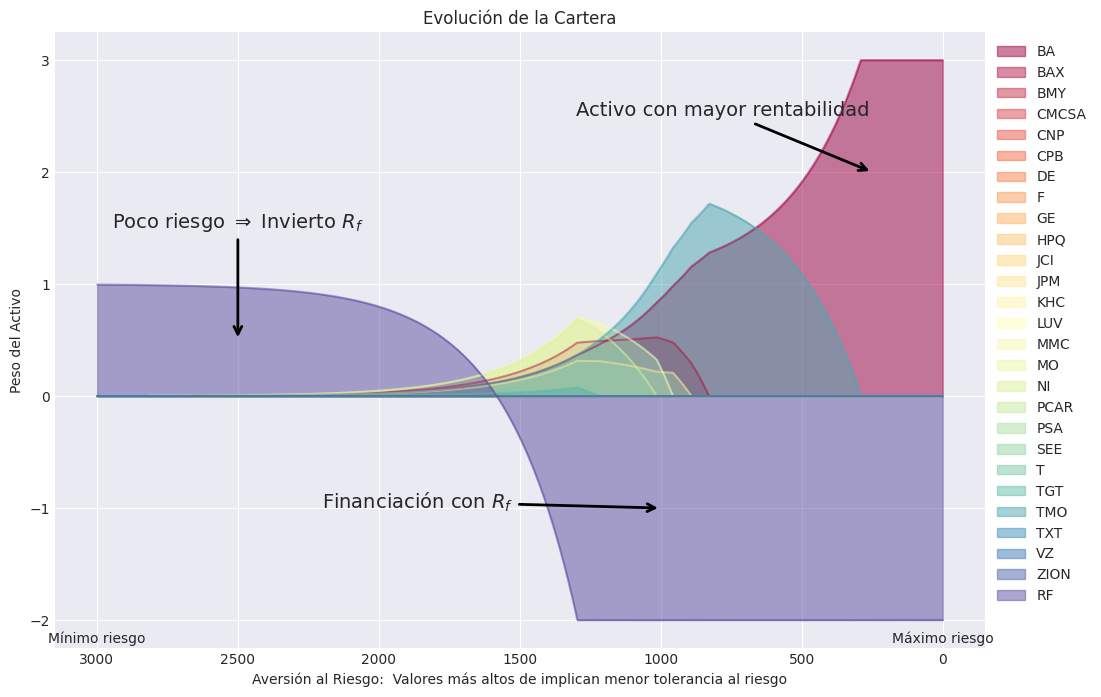

In [68]:

# Genero un dataframe con los pesos de las carteras óptimas
pesos_rf_df = pd.DataFrame(pesos_res_rf, columns=assets)


paleta = cm.get_cmap('Spectral', num_act)
#matplotlib.colormaps['Spectral']
colores = [paleta(i) for i in range(num_act)]

pesos_rf_df.plot.area(stacked=False, figsize=(12, 8), title='Pesos Carteras Óptimas', color=colores)

# Invertir el eje x
plt.gca().invert_xaxis()

# Añadir texto personalizado en el eje x
plt.text(3000, -2.2, 'Mínimo riesgo', ha='center')  # Cerca del 100
plt.text(0, -2.2, 'Máximo riesgo', ha='center')         # Cerca del 0

# Añadir una flecha
plt.annotate(f'Financiación con $R_f$', xy=(1000, -1), xytext=(2200, -1),
             arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=2),
             fontsize=14)

plt.annotate('Activo con mayor rentabilidad', xy=(250, 2), xytext=(1300, 2.5),
             arrowprops=dict(facecolor='red', arrowstyle='->', linewidth=2),
             fontsize=14)

plt.annotate('Poco riesgo $\\Rightarrow$ Invierto $R_f$', xy=(2500, 0.5), xytext=(2500, 1.5),
             arrowprops=dict(facecolor='green', arrowstyle='->', linewidth=2),
             fontsize=14, horizontalalignment='center')

plt.xlabel('Aversión al Riesgo:  Valores más altos de implican menor tolerancia al riesgo')
plt.ylabel('Peso del Activo')
plt.title('Evolución de la Cartera')

# Ajustar la leyenda fuera del área del gráfico
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show();

Existe una cartera en la que no existe $R_f$ llamada **Cartera de Mercado**, más adelante explicaremos qué significa esa cartera

In [90]:
pesos_rf_df[pesos_rf_df['RF'] == 0]

,BA,BAX,BMY,CMCSA,CNP,CPB,DE,F,GE,HPQ,...,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION,RF
1582,12.2795%,15.9158%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,...,0.0000%,0.0000%,0.0000%,0.0000%,2.5766%,12.2787%,0.0000%,0.0000%,0.0000%,0.0000%


In [88]:
cartera_mercado = pesos_rf_df[pesos_rf_df['RF'] == 0]

cartera_mercado = cartera_mercado.loc[:, (pesos_rf_df[pesos_rf_df['RF'] == 0] != 0).any(axis=0)]

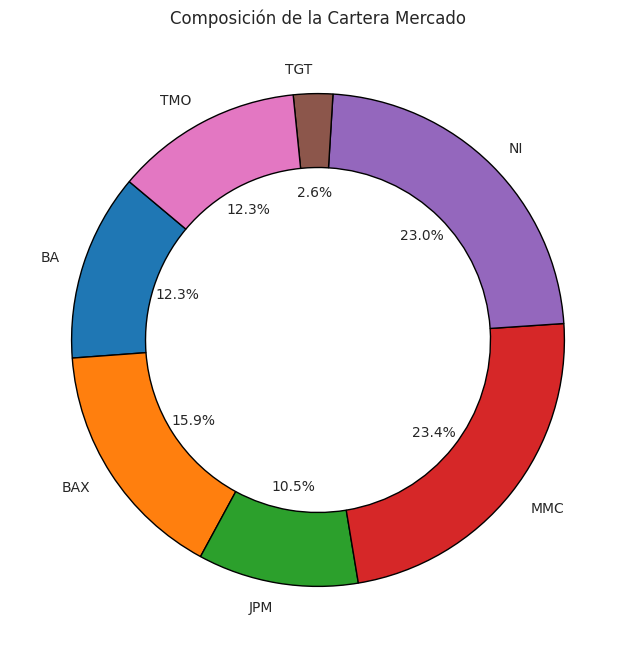

In [89]:
# Crear el gráfico de donut
plt.figure(figsize=(8, 8))

plt.pie(cartera_mercado.values[0], labels=cartera_mercado.columns, autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.3, 'edgecolor': 'black'})

# Añadir título
plt.title('Composición de la Cartera Mercado')

# Mostrar el gráfico
plt.show()